# Time Segmented Off Resonance Correction with PulPy

Off resonance behavior in the presence of time-varying gradients can produce distortion of a desired spatial domain excitation pattern. In this tutorial, we will demonstrate how to use PulPy's time segmented off-resonance correction feature to correct for an off resonance pattern.

# All imports:

In [8]:
import sys

import numpy as np

import pulpy as pp
import pulpy.rf as rf
import pulpy.grad as grad

import scipy as sc
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import scipy.ndimage.filters as filt
import sigpy.mri as mr
import matplotlib.pyplot as plt


# Set up a target excitation pattern:

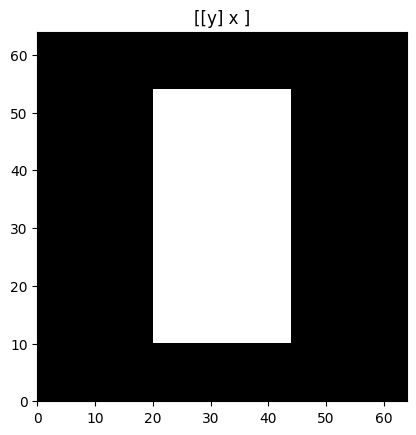

In [3]:
dim = 64
img_shape = [dim, dim]
sens_shape = [8, dim, dim]
target = np.zeros((dim,dim), dtype=complex)
target[10:54, 20:44] = 1
pl.ImagePlot(target)

# Simulate Tx coil sensitivities:

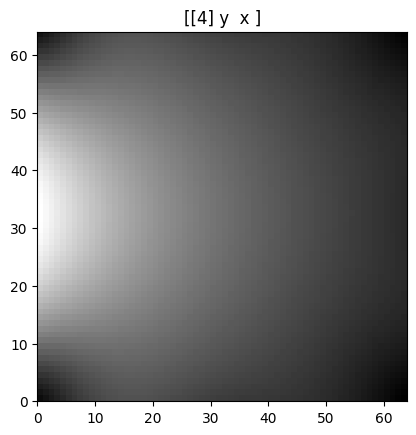

In [4]:
sens = mr.sim.birdcage_maps(sens_shape)
pl.ImagePlot(sens)

# Create an inhomogeneity pattern:

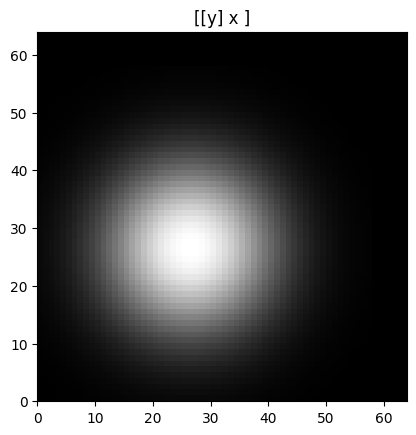

In [5]:
# inhomogeneity pattern - 2D off-center gaussian
x, y = np.ogrid[-img_shape[0] / 2: img_shape[0] - img_shape[0] / 2,
       -img_shape[1] / 2: img_shape[1] - img_shape[1] / 2]
B0 = np.zeros(img_shape)
d = np.sqrt(x * x + y * y)
sigma, mu, a = 10, 0.5, 50000
B0 = a * np.exp(-((d - mu) ** 2 / (2.0 * sigma ** 2)))
B0 = sc.ndimage.shift(B0, -6)
pl.ImagePlot(B0)

# Create an excitation trajectory:

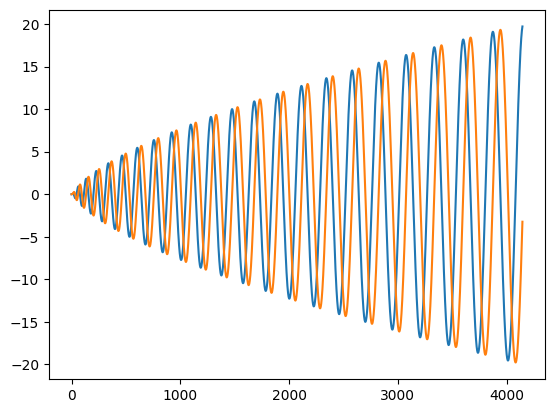

In [17]:
dt = 4E-6
fov = 0.55  # FOV in m
N = dim  # matrix size
gslew = 14500  # gradient slew rate in mT/m/ms
gamp = 30 # maximum gradient amplitude in mT/m
densamp = 10000  # duration of full density sampling (in samples)
dentrans = 10000  # duration of transition from low-high density (in samples)
R = 0.5  # degree of undersampling of outer region of trajectory- let's oversample by a factor of 2
dx = 0.025 # in m
rewinder = False
# construct a trajectory
g, k, t, s = grad.spiral_arch(fov/R,dx,dt,gslew,gamp)
plt.plot(np.transpose(k[:,0]))
plt.plot(np.transpose(k[:,1]))

# Design with off-resonance correction:

Now that we have our problem set up: target pattern, known inhomogeneity, and excitation trajectory, the last step to perform before performing the design is to set up our time segmented off resonance correction. This is done with a python dictionary:

In [18]:
tseg = {'b0': B0, 'dt': dt, 'n_bins': 40, 'lseg': 4}


Where B0, dt, the number of histogram bins, and the number of time segments used must all be specified. This dictionary is then passed as an argument into our pulse designer.

In [19]:
pulses_noB0 = rf.stspa(target, sens, k, dt, alpha=1, b0=None, phase_update_interval=10, explicit=False,
          max_iter=100, tol=1E-9)

pulses_B0 = rf.stspa(target, sens, k, dt, alpha=1, tseg=tseg, phase_update_interval=10, explicit=False,
          max_iter=100, tol=1E-9)

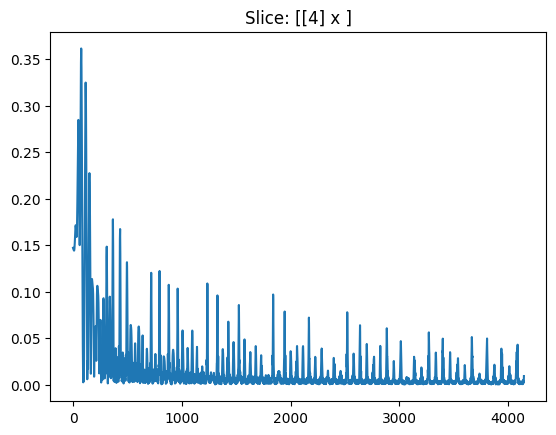

In [20]:
pl.LinePlot(pulses_B0)

Finally, let's compare the two patterns that were produced: 

In [21]:
A = sp.mri.linop.Sense(sens, k, weights=None, tseg=tseg, ishape=target.shape).H


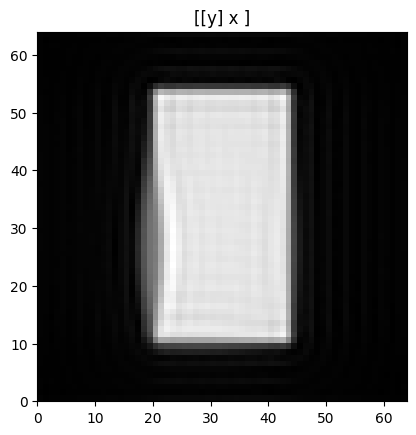

In [22]:
pl.ImagePlot(A*pulses_noB0)


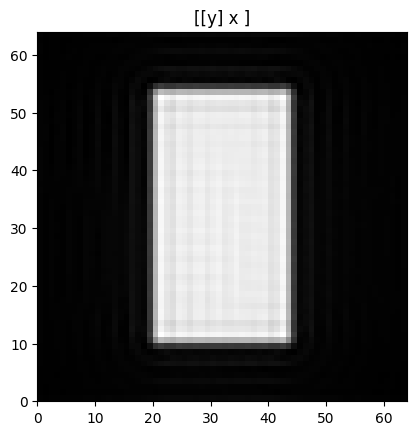

In [23]:
pl.ImagePlot(A*pulses_B0)


The distortion is successfully corrected!